In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
infotable = f'/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/irf_random/crab/regression_5sgm_5000sz.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS'])
DS dataset size: 5000


In [2]:
from astroai.tools.utils import split_regression_dataset

train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, infotable, split=80, reshape=True, binning=250)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(4000, 250, 250) (4000, 2)
Train dataset: 4000, (4000, 250, 250, 1)
Train labels: 4000, (4000, 2)

Test dataset: 1000, (1000, 250, 250, 1)
Test labels: 1000, (1000, 2)


In [3]:
import matplotlib.pyplot as plt
def plot_heatmap_wcs(heatmap, title='heatmap', show=False, save=False, save_name=None, wcs=None, src=None):
    if wcs is not None:
        ax = plt.subplot(projection=wcs)
        ax.coords[0].set_format_unit('deg')
        ax.coords[1].set_format_unit('deg')
        #ax.invert_xaxis()
        #ax.invert_yaxis()
    else:
        ax = plt.subplot()
    plt.title(title)
    plt.imshow(heatmap, vmin=0, vmax=1)
    plt.scatter(src[0], src[1], marker='o', s=50, facecolor='none', edgecolor='k')
    plt.xlabel('x(det) [pixels]')
    plt.ylabel('y(det) [pixels]')
    plt.colorbar()
    if save and save_name is not None:
        plt.savefig(save_name)
    if show:
        plt.show()
    plt.close()
    return

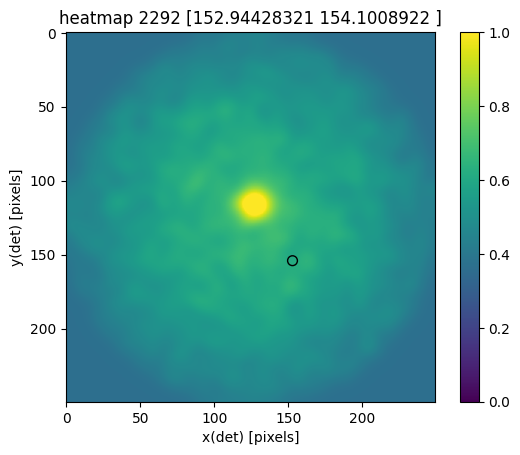

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
4291,crab_02292,2292,0,300,300,97.959658,59.679999,100.088047,58.021692,1.990272,North_z20_N_5h_LST,2.5,7.489008


In [4]:
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(train_data)))
binning = 250
with_wcs = False

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==idx]

# create wcs
if with_wcs:
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=binning/2+0.5, pixelsize=row['fov'].values[0]/binning)
    src = (row['source_ra'].values[0], row['source_dec'].values[0])
else:
    w = None
    src = train_labels[idx]

# plot map
plot_heatmap_wcs(train_data[idx], title=f'heatmap {idx} {train_labels[idx]}', wcs=w, src=src,
                 show=True, save=False, save_name=None)

# print row info
row

### Check WCS to pixel conversion

In [5]:
from astroai.tools.utils import *

w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=250/2+0.5, pixelsize=row['fov'].values[0]/250)
x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], unit='deg'))
x, y

(array(231.97477546), array(292.02404154))

In [6]:
sky = w.pixel_to_world(x, y)
sky

<SkyCoord (ICRS): (ra, dec) in deg
    (97.95965804, 59.67999859)>